**Step 1: Install & Import Libraries**

In [1]:
# Install Kaggle API (if not already installed)
!pip install kaggle

In [11]:
# Import libraries
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.layers import Dropout

**Step 2: Upload Kaggle API Key Download Dataset**

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samidiprarthana","key":"575bf96b134f0c66cfeaeb20d24fbca1"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Download the dataset

In [5]:
!kaggle datasets download -d uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka

Dataset URL: https://www.kaggle.com/datasets/uthpalabandara/common-diseases-of-tea-leaves-in-sri-lanka
License(s): MIT
 99% 951M/960M [00:11<00:00, 110MB/s] 
100% 960M/960M [00:11<00:00, 90.1MB/s]


Unzip the dataset

In [6]:
!unzip common-diseases-of-tea-leaves-in-sri-lanka.zip -d tea_leaf_dataset

Archive:  common-diseases-of-tea-leaves-in-sri-lanka.zip
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_1 - Copy.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_1.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_10.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_11.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_12.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_13.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_14.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_15.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_16.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_17.jpg  
  inflating: tea_leaf_dataset/Algal Leaf/Algal Leaf/UNADJUSTEDNONRAW_thumb_18.jpg  
  inflating: t

Verify the Dataset

In [7]:
import os

data_dir = 'tea_leaf_dataset'
print(os.listdir(data_dir))  # Should list disease class folders


['White Spot', 'Algal Leaf', 'Gray Light', 'Bird Eye Spot', 'Red Leaf Spot', 'Brown Blight', 'Anthracnose', 'Healthy']


**Step 3: Visualize Dataset**

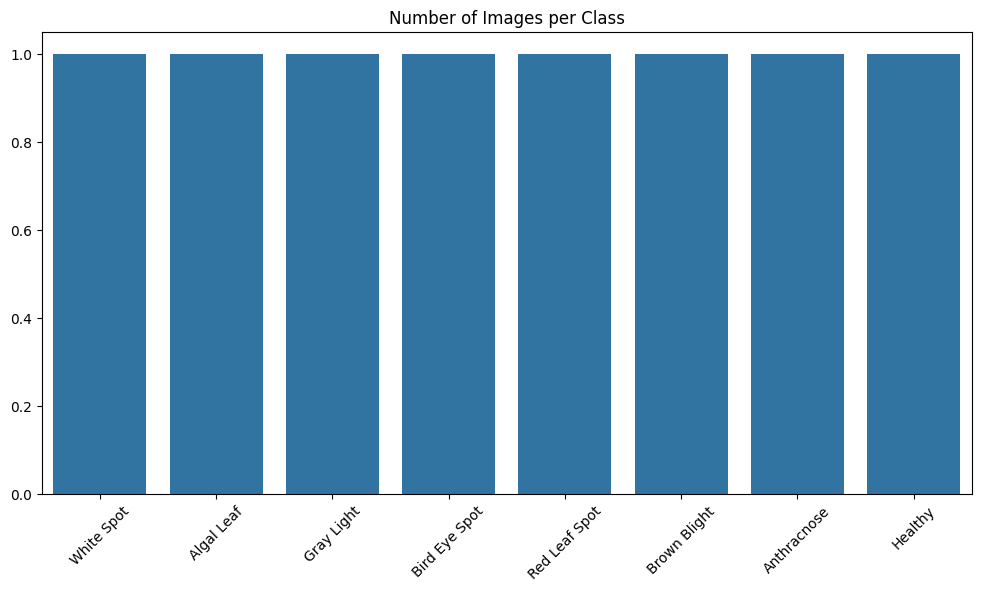

In [8]:
data_dir = 'tea_leaf_dataset'
classes = os.listdir(data_dir)

# Count images per class
counts = {cls: len(os.listdir(os.path.join(data_dir, cls))) for cls in classes}

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.show()

**Step 4: Data Preprocessing & Augmentation**

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

#Training data with augmentation
from tensorflow.keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)



Found 960 images belonging to 8 classes.
Found 236 images belonging to 8 classes.
Found 236 images belonging to 8 classes.


In [10]:
num_classes = len(train_generator.class_indices)
print("Classes:", train_generator.class_indices)
print("Train samples:", train_generator.samples, "Validation samples:", validation_generator.samples)


Classes: {'Algal Leaf': 0, 'Anthracnose': 1, 'Bird Eye Spot': 2, 'Brown Blight': 3, 'Gray Light': 4, 'Healthy': 5, 'Red Leaf Spot': 6, 'White Spot': 7}
Train samples: 960 Validation samples: 236


**p 5: Build ResNet50 Model**

In [12]:
num_classes = len(train_generator.class_indices)

# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 126,357,384 (482.02 MB)

 Trainable params: 102,769,672 (392.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

**Step 6: Train the Model**

In [13]:
EPOCHS = 25

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3388 - loss: 6.3815 - val_accuracy: 0.5975 - val_loss: 2.4167
Epoch 2/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6293 - loss: 2.3253 - val_accuracy: 0.6780 - val_loss: 1.2904
Epoch 3/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.6913 - loss: 1.3565 - val_accuracy: 0.6186 - val_loss: 1.3991
Epoch 4/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7243 - loss: 0.9729 - val_accuracy: 0.6864 - val_loss: 1.0289
Epoch 5/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7289 - loss: 0.7666 - val_accuracy: 0.6864 - val_loss: 0.9132
Epoch 6/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7662 - loss: 0.6049 - val_accuracy: 0.7034 - val_loss: 0.8855
Epoch 7/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.7733 - loss: 0.6081 - val_accuracy: 0.7203 - val_loss: 0.8487
Epoch 8/25
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.7717 - loss: 0.6517 - val_accuracy: 0.6949 - val_loss:

**Step 7: Fine-Tuning**

In [14]:
# Unfreeze top 10 layers for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile with lower learning rate
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

FINE_TUNE_EPOCHS = 15

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=FINE_TUNE_EPOCHS
)


Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8298 - loss: 0.4366 - val_accuracy: 0.7669 - val_loss: 0.8239
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9053 - loss: 0.2840 - val_accuracy: 0.7500 - val_loss: 0.8619
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8737 - loss: 0.3474 - val_accuracy: 0.7500 - val_loss: 0.7801
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.9011 - loss: 0.2676 - val_accuracy: 0.7373 - val_loss: 0.9194
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8770 - loss: 0.3285 - val_accuracy: 0.7669 - val_loss: 0.7234
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9121 - loss: 0.2380 - val_accuracy: 0.7924 - val_loss: 0.7547
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9253 - loss: 0.2139 - val_accuracy: 0.7754 - val_loss: 0.7151
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8880 - loss: 0.2654 - val_accuracy: 0.7458 - val_loss:

**Train longer with callbacks**

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_resnet50.h5', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9282 - loss: 0.2069

30/30 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9283 - loss: 0.2063 - val_accuracy: 0.7712 - val_loss: 0.7714
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9371 - loss: 0.1640

30/30 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9373 - loss: 0.1641 - val_accuracy: 0.8051 - val_loss: 0.6902
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9185 - loss: 0.2134 - val_accuracy: 0.7839 - val_loss: 0.7619
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.9539 - loss: 0.1404 - val_accuracy: 0.7839 - val_loss: 0.7881
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9420 - loss: 0.1600 - val_accuracy: 0.7797 - val_loss: 0.7458
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9514 - loss: 0.1364 - val_accuracy: 0.7797 - val_loss: 0.8036
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.9342 - loss: 0.1534 - val_accuracy: 0.7966 - val_loss: 0.9738


**Step 8: Visualize Training Progress**

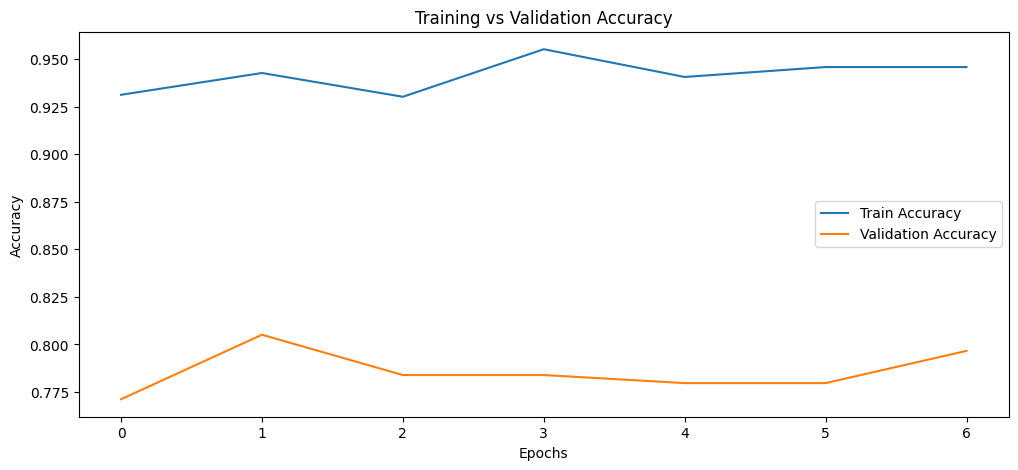

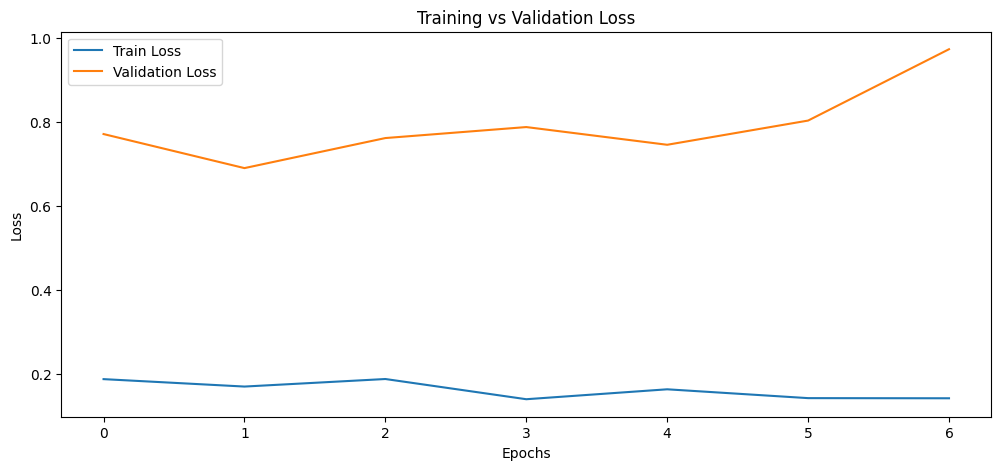

In [16]:
# Plot Accuracy
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Step 9: Evaluate Model**

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Confusion Matrix
[[ 4  4  2  1  5  3  6  5]
 [ 3  0  5  0  2  3  7  5]
 [ 3  2  2  6  3  3  6  2]
 [ 5  2  1  4  4  1  5  6]
 [ 4  1  0  1  3  4  4  7]
 [ 4  2  3  2  2  2  3  2]
 [ 4  4  5  4 11  1  7  8]
 [ 7  5  5  2  4  3  5  7]]


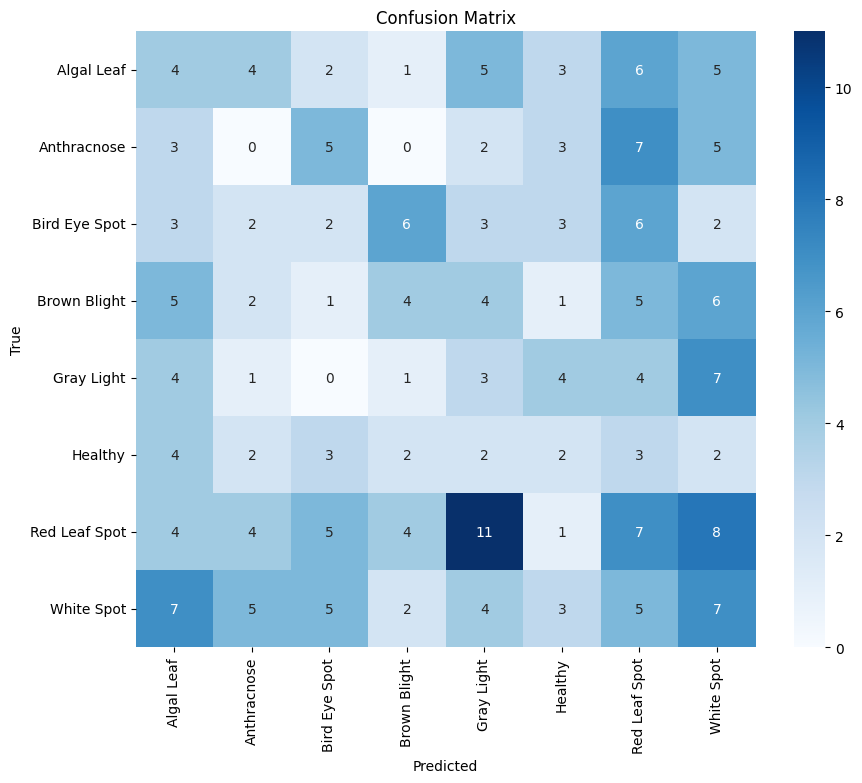

Classification Report
               precision    recall  f1-score   support

   Algal Leaf       0.12      0.13      0.12        30
  Anthracnose       0.00      0.00      0.00        25
Bird Eye Spot       0.09      0.07      0.08        27
 Brown Blight       0.20      0.14      0.17        28
   Gray Light       0.09      0.12      0.10        24
      Healthy       0.10      0.10      0.10        20
Red Leaf Spot       0.16      0.16      0.16        44
   White Spot       0.17      0.18      0.17        38

     accuracy                           0.12       236
    macro avg       0.12      0.11      0.11       236
 weighted avg       0.12      0.12      0.12       236



In [17]:
# Get predictions
validation_generator.reset()
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion Matrix
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred), annot=True, fmt='d', xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))


**Step 10: Save Model**

In [18]:
model.save('resnet50_tea_leaf_model.h5')

In [19]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7823 - loss: 0.6487
Validation Accuracy: 76.27%
Validation Loss: 0.7464


In [20]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7840 - loss: 0.8486
Test Accuracy: 78.39%
Test Loss: 0.8660


**Step 11 : Model Predictions**

In [21]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import tensorflow as tf
import glob

In [31]:
#  Set your dataset directory
data_dir = 'tea_leaf_dataset'

In [30]:
#  Load the trained model
model = load_model('resnet50_tea_leaf_model.h5')

In [32]:
#  Pick a random class folder
random_class = random.choice(os.listdir(data_dir))
class_path = os.path.join(data_dir, random_class)

In [33]:
# Get all image files in the class folder (handles nested folders)
all_images = glob.glob(os.path.join(class_path, '*/*.jpg')) + \
             glob.glob(os.path.join(class_path, '*/*.jpeg')) + \
             glob.glob(os.path.join(class_path, '*/*.png'))

In [41]:
# Pick a random image
img_path = random.choice(all_images)

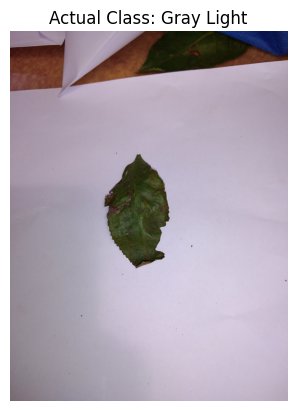

In [35]:
# Display the selected image
plt.imshow(plt.imread(img_path))
plt.title(f"Actual Class: {random_class}")
plt.axis('off')
plt.show()

In [36]:
#  Preprocess the image for ResNet50
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

In [37]:
# Make prediction
pred = model.predict(img_array)
predicted_class = list(train_generator.class_indices.keys())[np.argmax(pred)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


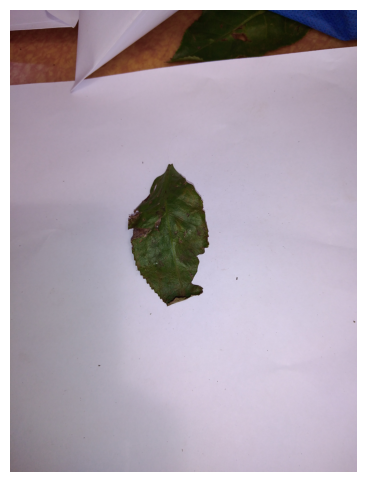

 Predicted Class: Gray Light
 Actual Class: Gray Light


In [39]:
#  Show results
plt.figure(figsize=(6,6))
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()
print(" Predicted Class:", predicted_class)
print(" Actual Class:", random_class)

**Predict on  Own Image**

In [44]:
from google.colab import files

# This will open a file chooser in Colab
uploaded = files.upload()


Saving UNADJUSTEDNONRAW_thumb_1a0 - Copy.jpg to UNADJUSTEDNONRAW_thumb_1a0 - Copy.jpg


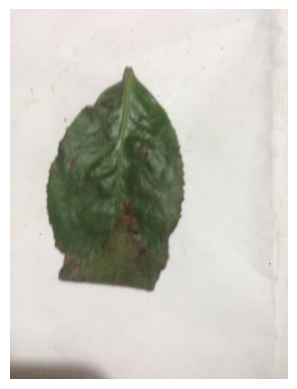

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


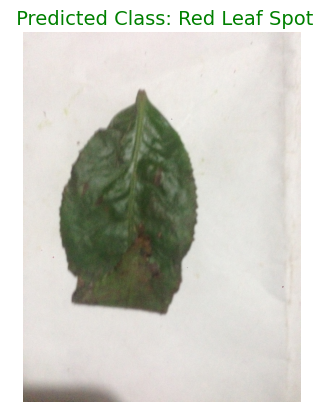

 Predicted Class: Red Leaf Spot


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.models import load_model

#  Load the trained model (if not already in memory)
model = load_model('resnet50_tea_leaf_model.h5')

#  Get the uploaded file path
img_path = list(uploaded.keys())[0]  # gets the first uploaded image

#  Display the image
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.show()

#  Preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

#  Predict class
pred = model.predict(img_array)
predicted_class = list(train_generator.class_indices.keys())[np.argmax(pred)]

#  Show result on the image
plt.imshow(plt.imread(img_path))
plt.axis('off')
plt.title(f" Predicted Class: {predicted_class}", fontsize=14, color='green')
plt.show()

print(" Predicted Class:", predicted_class)
